# Preamble

In [1]:
%cd ../../../..
%pwd

/home/andrej/myStuff/berkeley/STAT215A/assignments/final


'/home/andrej/myStuff/berkeley/STAT215A/assignments/final'

In [2]:
import os
import pickle as pkl

import numpy as np
import pandas as pd
from sklearn import metrics

import imodels

from rulevetting.api import validation

from rulevetting.projects.tbi_pecarn.dataset import *

In [52]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams['figure.dpi'] = 300

## Loading Data with Default Judgement Calls

In [3]:
dset = Dataset()

# Basic Model - `rulefit` rule set , minimal data set

Union / drop whenever possible

In [4]:
judg_calls = \
    {
        'clean_data'      : {},
        'preprocess_data' : {
            # Unioning policies:
            # 1: union - impute parent from children, drop children
            # 2: mixed: keep (some) children & parent, impute parent from the children kept
            # 3: no: no imputation, keep all children, drop those with N/A in any child
            # Include how the injury occurred
            "step1_injMech"   : False,
            "step5_missSubGCS": True,
            "step5_fake15GCS" : True,
            "step5_fake14GCS" : False,
            # GCS < 15, or other signs of altered mental status
            "step7_AMS"       : 1,
            # Evidence of substantial non-head injuries
            "step8_OSI"       : 1,
            # Raised scalp hematoma or swelling?
            "step9_HEMA"      : 1,
            # Palpable skull fracture?
            "step10_SFx"      : 1,
            # Signs of basilar skull fracture?
            "step11_SFxBas"   : 1,
            # Evidence of trauma above the clavicles
            "step12_Clav"     : 1,
            # Evidence of neurological deficit, besides altered mental status
            "step13_NeuroD"   : 1,
            # Whether the individual vomited after the injury
            "step14_Vomit"    : 1,
            # Whether there was a headache at the time of evaluation
            "step15_HA"       : 1,
            # only affects 3 above
            "step15_HAStart"  : False,
            # Whether there was a seizure
            "step16_Seiz"     : 1,
            # only affects 3 above
            "step16_SeizOccur": False,
            # History of loss of consciousness
            "step17_LOC"      : 1,
            # Clinical suspicion for alcohol or drug intoxication
            "step19_Drugs"    : False,
            # Whether the parent thinks the child is acting normally
            "step20_ActNormal": True

        },
        'extract_features': {
            "HEMA_umbrella"   : False,
            "SFxPalp_umbrella": False,
            "SFxBas_umbrella" : False,
            "AMS_umbrella"    : False,
            "OSI_umbrella"    : False,
            "Clav_umbrella"   : False,
            "NeuroD_umbrella" : False,
            "Vomit_umbrella"  : False,
            "HA_umbrella"     : False,
            "Seiz_umbrella"   : False,
            "LOC_umbrella"    : False,
            # binarize GCS
            "GCS"             : False,
            # remove columns with const values
            "remove_constVal" : True
        },
    }

In [5]:
df_train, df_tune, df_test = dset.get_data(split_age=AgeSplit.NOSPLIT, **judg_calls)

kwargs {'clean_data': {}, 'preprocess_data': {'step1_injMech': False, 'step5_missSubGCS': True, 'step5_fake15GCS': True, 'step5_fake14GCS': False, 'step7_AMS': 1, 'step8_OSI': 1, 'step9_HEMA': 1, 'step10_SFx': 1, 'step11_SFxBas': 1, 'step12_Clav': 1, 'step13_NeuroD': 1, 'step14_Vomit': 1, 'step15_HA': 1, 'step15_HAStart': False, 'step16_Seiz': 1, 'step16_SeizOccur': False, 'step17_LOC': 1, 'step19_Drugs': False, 'step20_ActNormal': True}, 'extract_features': {'HEMA_umbrella': False, 'SFxPalp_umbrella': False, 'SFxBas_umbrella': False, 'AMS_umbrella': False, 'OSI_umbrella': False, 'Clav_umbrella': False, 'NeuroD_umbrella': False, 'Vomit_umbrella': False, 'HA_umbrella': False, 'Seiz_umbrella': False, 'LOC_umbrella': False, 'GCS': False, 'remove_constVal': True}}


In [6]:
print(len(df_train), len(df_tune), len(df_test))

2050 684 684


In [7]:
feature_names = list(df_train)
for col in dset.get_meta_keys() + [dset.get_outcome_name()]:
    try:
        feature_names.remove(col)
    except ValueError:
        pass

In [8]:
feature_names

['LOCSeparate',
 'Seiz',
 'ActNorm',
 'HA_verb',
 'Vomit',
 'GCSTotal',
 'AMS',
 'SFxPalp',
 'SFxBas',
 'Hema',
 'Clav',
 'NeuroD',
 'OSI',
 'AgeinYears',
 'High_impact_InjSev_1',
 'High_impact_InjSev_2',
 'High_impact_InjSev_3',
 'Amnesia_verb_0',
 'Amnesia_verb_1',
 'Amnesia_verb_91']

In [9]:
any(pd.isna(df_train.loc[:, feature_names]))

True

In [10]:
np.sum(pd.isna(df_train.loc[:, feature_names]))

LOCSeparate             0
Seiz                    0
ActNorm                 0
HA_verb                 0
Vomit                   0
GCSTotal                0
AMS                     0
SFxPalp                 0
SFxBas                  0
Hema                    0
Clav                    0
NeuroD                  0
OSI                     0
AgeinYears              0
High_impact_InjSev_1    0
High_impact_InjSev_2    0
High_impact_InjSev_3    0
Amnesia_verb_0          0
Amnesia_verb_1          0
Amnesia_verb_91         0
dtype: int64

In [25]:
rulefit = imodels.RuleFitClassifier(max_rules=10, include_linear=False)
rulefit.fit(df_train.loc[:, feature_names], df_train.outcome, feature_names=feature_names)

RuleFitClassifier(include_linear=False, max_rules=10)

In [56]:
pkl.dump(rulefit, open("rulevetting/projects/tbi_pecarn/notebooks/models/basic.pkl", 'wb'))

In [43]:
def predict_and_save(model, model_name, X_train, X_tune, y_train, y_tune):
    '''Plots cv and returns cv, saves all stats
    '''
    
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=False)
                                                     #plot=suffix == '_tune')
#         plt.xlim(0, 1)
#         plt.ylim(0, 1)
        
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes

    return stats, threshes

In [37]:
statsB, threshesB = predict_and_save(rulefit, 'rulefit',
                                   df_train.loc[:, feature_names],
                                   df_tune.loc[:, feature_names],
                                   df_train.outcome,
                                   df_tune.outcome,
                                   plot=False)

100%|██████████| 57/57 [00:00<00:00, 1589.33it/s]


(0.0, 1.0)

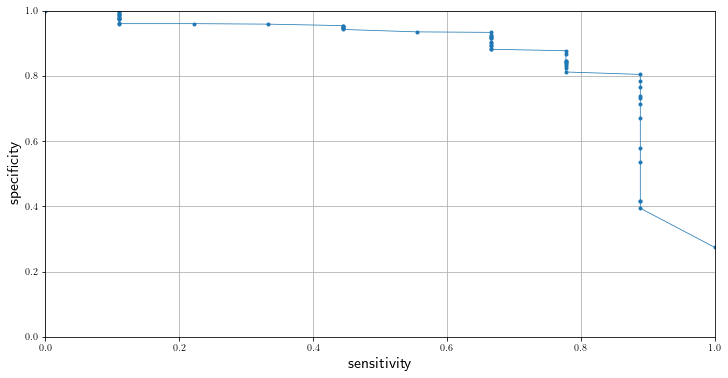

In [36]:
plt.plot(stats['sens'], stats['spec'], '.-')
plt.xlabel('sensitivity', fontsize=16)
plt.ylabel('specificity', fontsize=16)
plt.grid()
plt.xlim(0, 1);
plt.ylim(0, 1);


In [14]:
# TODO: check what the linear is 

In [26]:
rules = rulefit.get_rules()
rules.sort_values("importance", ascending=False)

,rule,type,coef,support,importance
2,Seiz <= 0.5 and AMS <= 0.5,rule,-0.829104,0.829268,0.311970
6,Vomit <= 0.5,rule,-1.029020,0.929756,0.262974
9,GCSTotal > 0.5 and SFxPalp <= 0.5 and SFxBas <...,rule,-0.830345,0.925366,0.218215
1,LOCSeparate <= 0.5,rule,-0.406852,0.703415,0.185831
5,Seiz <= 0.5 and Hema <= 0.5,rule,-0.228116,0.678537,0.106539
8,GCSTotal > 0.5 and SFxBas <= 0.5,rule,-0.304168,0.947317,0.067951
0,SFxBas <= 0.5 and Hema <= 0.5,rule,-0.138522,0.678537,0.064695
4,OSI > 0.5 and High_impact_InjSev_1 <= 0.5 and ...,rule,-0.201357,0.928780,0.051787
7,Seiz <= 0.5 and SFxBas <= 0.5,rule,-0.270432,0.982439,0.035521
3,High_impact_InjSev_3 <= 0.5 and GCSTotal > 0.5...,rule,-0.011672,0.692683,0.005385


## Splitting by age

In [13]:
df_trainO, df_tuneO, df_testO = dset.get_data(split_age=AgeSplit.OLD ,**judg_calls)
feature_namesO = list(df_trainO)
for col in dset.get_meta_keys() + [dset.get_outcome_name()]:
    try:
        feature_namesO.remove(col)
    except ValueError:
        pass
    
rulefit = imodels.RuleFitClassifier(max_rules=10)
rulefit.fit(df_trainO.loc[:, feature_namesO], df_trainO.outcome, feature_names=feature_namesO)

sy, ty = predict_and_save(rulefit, 'rulefit',
                                   df_trainO.loc[:, feature_namesO],
                                   df_tuneO.loc[:, feature_namesO],
                                   df_trainO.outcome,
                                   df_tuneO.outcome)

kwargs {'clean_data': {}, 'preprocess_data': {'step1_injMech': False, 'step5_missSubGCS': True, 'step5_fake15GCS': True, 'step5_fake14GCS': False, 'step7_AMS': 1, 'step8_OSI': 1, 'step9_HEMA': 1, 'step10_SFx': 1, 'step11_SFxBas': 1, 'step12_Clav': 1, 'step13_NeuroD': 1, 'step14_Vomit': 1, 'step15_HA': 1, 'step15_HAStart': False, 'step16_Seiz': 1, 'step16_SeizOccur': False, 'step17_LOC': 1, 'step19_Drugs': False, 'step20_ActNormal': True}, 'extract_features': {'HEMA_umbrella': False, 'SFxPalp_umbrella': False, 'SFxBas_umbrella': False, 'AMS_umbrella': False, 'OSI_umbrella': False, 'Clav_umbrella': False, 'NeuroD_umbrella': False, 'Vomit_umbrella': False, 'HA_umbrella': False, 'Seiz_umbrella': False, 'LOC_umbrella': False, 'GCS': False, 'remove_constVal': True}}


NameError: name 'predict_and_save' is not defined

In [17]:
rules = rulefit.get_rules()
rules = rules[rules['type']!='linear']
rules = rules.sort_values('importance', ascending=False) 
rules

,rule,type,coef,support,importance
26,Amnesia_verb_91 <= 0.5 and Vomit <= 0.5,rule,-1.122153,0.901639,0.334179
27,Seiz <= 0.5 and AMS <= 0.5,rule,-0.565448,0.834973,0.209897
24,Seiz <= 0.5 and GCSTotal > 0.5 and SFxBas <= 0.5,rule,-0.844047,0.944262,0.193637
23,GCSTotal > 0.5 and SFxBas <= 0.5,rule,-0.712370,0.951913,0.152412
22,LOCSeparate <= 0.5,rule,-0.216551,0.677049,0.101260
20,SFxBas <= 0.5 and Hema <= 0.5,rule,-0.210025,0.682514,0.097766
28,Seiz <= 0.5 and SFxBas <= 0.5,rule,-0.266542,0.983607,0.033846
21,High_impact_InjSev_3 <= 0.5 and GCSTotal > 0.5,rule,-0.059321,0.706557,0.027011
25,Vomit <= 0.5,rule,-0.061141,0.932787,0.015309
29,Seiz <= 0.5 and SFxBas <= 0.5,rule,-0.057845,0.983607,0.007345


**NOTE:** the drop-off above 80% sensitivity in both cases!

# Maximal model

In [38]:
judg_calls_max = \
    {
        'clean_data'      : {},
        'preprocess_data' : {
            # Unioning policies:
            # 1: union - impute parent from children, drop children
            # 2: mixed: keep (some) children & parent, impute parent from the children kept
            # 3: no: no imputation, keep all children, drop those with N/A in any child
            # Include how the injury occurred
            "step1_injMech"   : True,
            "step5_missSubGCS": True,
            "step5_fake15GCS" : True,
            "step5_fake14GCS" : True,
            # GCS < 15, or other signs of altered mental status
            "step7_AMS"       : 3,
            # Evidence of substantial non-head injuries
            "step8_OSI"       : 3,
            # Raised scalp hematoma or swelling?
            "step9_HEMA"      : 3,
            # Palpable skull fracture?
            "step10_SFx"      : 3,
            # Signs of basilar skull fracture?
            "step11_SFxBas"   : 3,
            # Evidence of trauma above the clavicles
            "step12_Clav"     : 3,
            # Evidence of neurological deficit, besides altered mental status
            "step13_NeuroD"   : 3,
            # Whether the individual vomited after the injury
            "step14_Vomit"    : 3,
            # Whether there was a headache at the time of evaluation
            "step15_HA"       : 3,
            # only affects 3 above
            "step15_HAStart"  : True,
            # Whether there was a seizure
            "step16_Seiz"     : 3,
            # only affects 3 above
            "step16_SeizOccur": 3,
            # History of loss of consciousness
            "step17_LOC"      : 3,
            # Clinical suspicion for alcohol or drug intoxication
            "step19_Drugs"    : True,
            # Whether the parent thinks the child is acting normally
            "step20_ActNormal": False

        },
        'extract_features': {
            "HEMA_umbrella"   : False,
            "SFxPalp_umbrella": False,
            "SFxBas_umbrella" : False,
            "AMS_umbrella"    : False,
            "OSI_umbrella"    : False,
            "Clav_umbrella"   : False,
            "NeuroD_umbrella" : False,
            "Vomit_umbrella"  : False,
            "HA_umbrella"     : False,
            "Seiz_umbrella"   : False,
            "LOC_umbrella"    : False,
            # binarize GCS
            "GCS"             : True,
            # remove columns with const values
            "remove_constVal" : True
        },
    }

In [39]:
df_trainM, df_tuneM, df_testM = dset.get_data(split_age=AgeSplit.NOSPLIT, **judg_calls_max)

kwargs {'clean_data': {}, 'preprocess_data': {'step1_injMech': True, 'step5_missSubGCS': True, 'step5_fake15GCS': True, 'step5_fake14GCS': True, 'step7_AMS': 3, 'step8_OSI': 3, 'step9_HEMA': 3, 'step10_SFx': 3, 'step11_SFxBas': 3, 'step12_Clav': 3, 'step13_NeuroD': 3, 'step14_Vomit': 3, 'step15_HA': 3, 'step15_HAStart': True, 'step16_Seiz': 3, 'step16_SeizOccur': 3, 'step17_LOC': 3, 'step19_Drugs': True, 'step20_ActNormal': False}, 'extract_features': {'HEMA_umbrella': False, 'SFxPalp_umbrella': False, 'SFxBas_umbrella': False, 'AMS_umbrella': False, 'OSI_umbrella': False, 'Clav_umbrella': False, 'NeuroD_umbrella': False, 'Vomit_umbrella': False, 'HA_umbrella': False, 'Seiz_umbrella': False, 'LOC_umbrella': False, 'GCS': True, 'remove_constVal': True}}


In [40]:
feature_namesM = list(df_trainM)
for col in dset.get_meta_keys() + [dset.get_outcome_name()]:
    try:
        feature_namesM.remove(col)
    except ValueError:
        pass

In [61]:
rulefitM = imodels.RuleFitClassifier(max_rules=20, include_linear=True)
rulefitM.fit(df_trainM.loc[:, feature_namesM], df_trainM.outcome, feature_names=feature_namesM)

RuleFitClassifier(max_rules=20)

In [62]:
pkl.dump(rulefitM, open("rulevetting/projects/tbi_pecarn/notebooks/models/maxim.pkl", 'wb'))

In [44]:
statsM, ty = predict_and_save(rulefitM, 'rulefit',
                                   df_trainM.loc[:, feature_namesM],
                                   df_tuneM.loc[:, feature_namesM],
                                   df_trainM.outcome,
                                   df_tuneM.outcome)

100%|██████████| 269/269 [00:00<00:00, 814.34it/s]


In [ ]:
pkl.dump(statsM, open("rulevetting/projects/tbi_pecarn/notebooks/models/maxim.pkl", 'wb'))

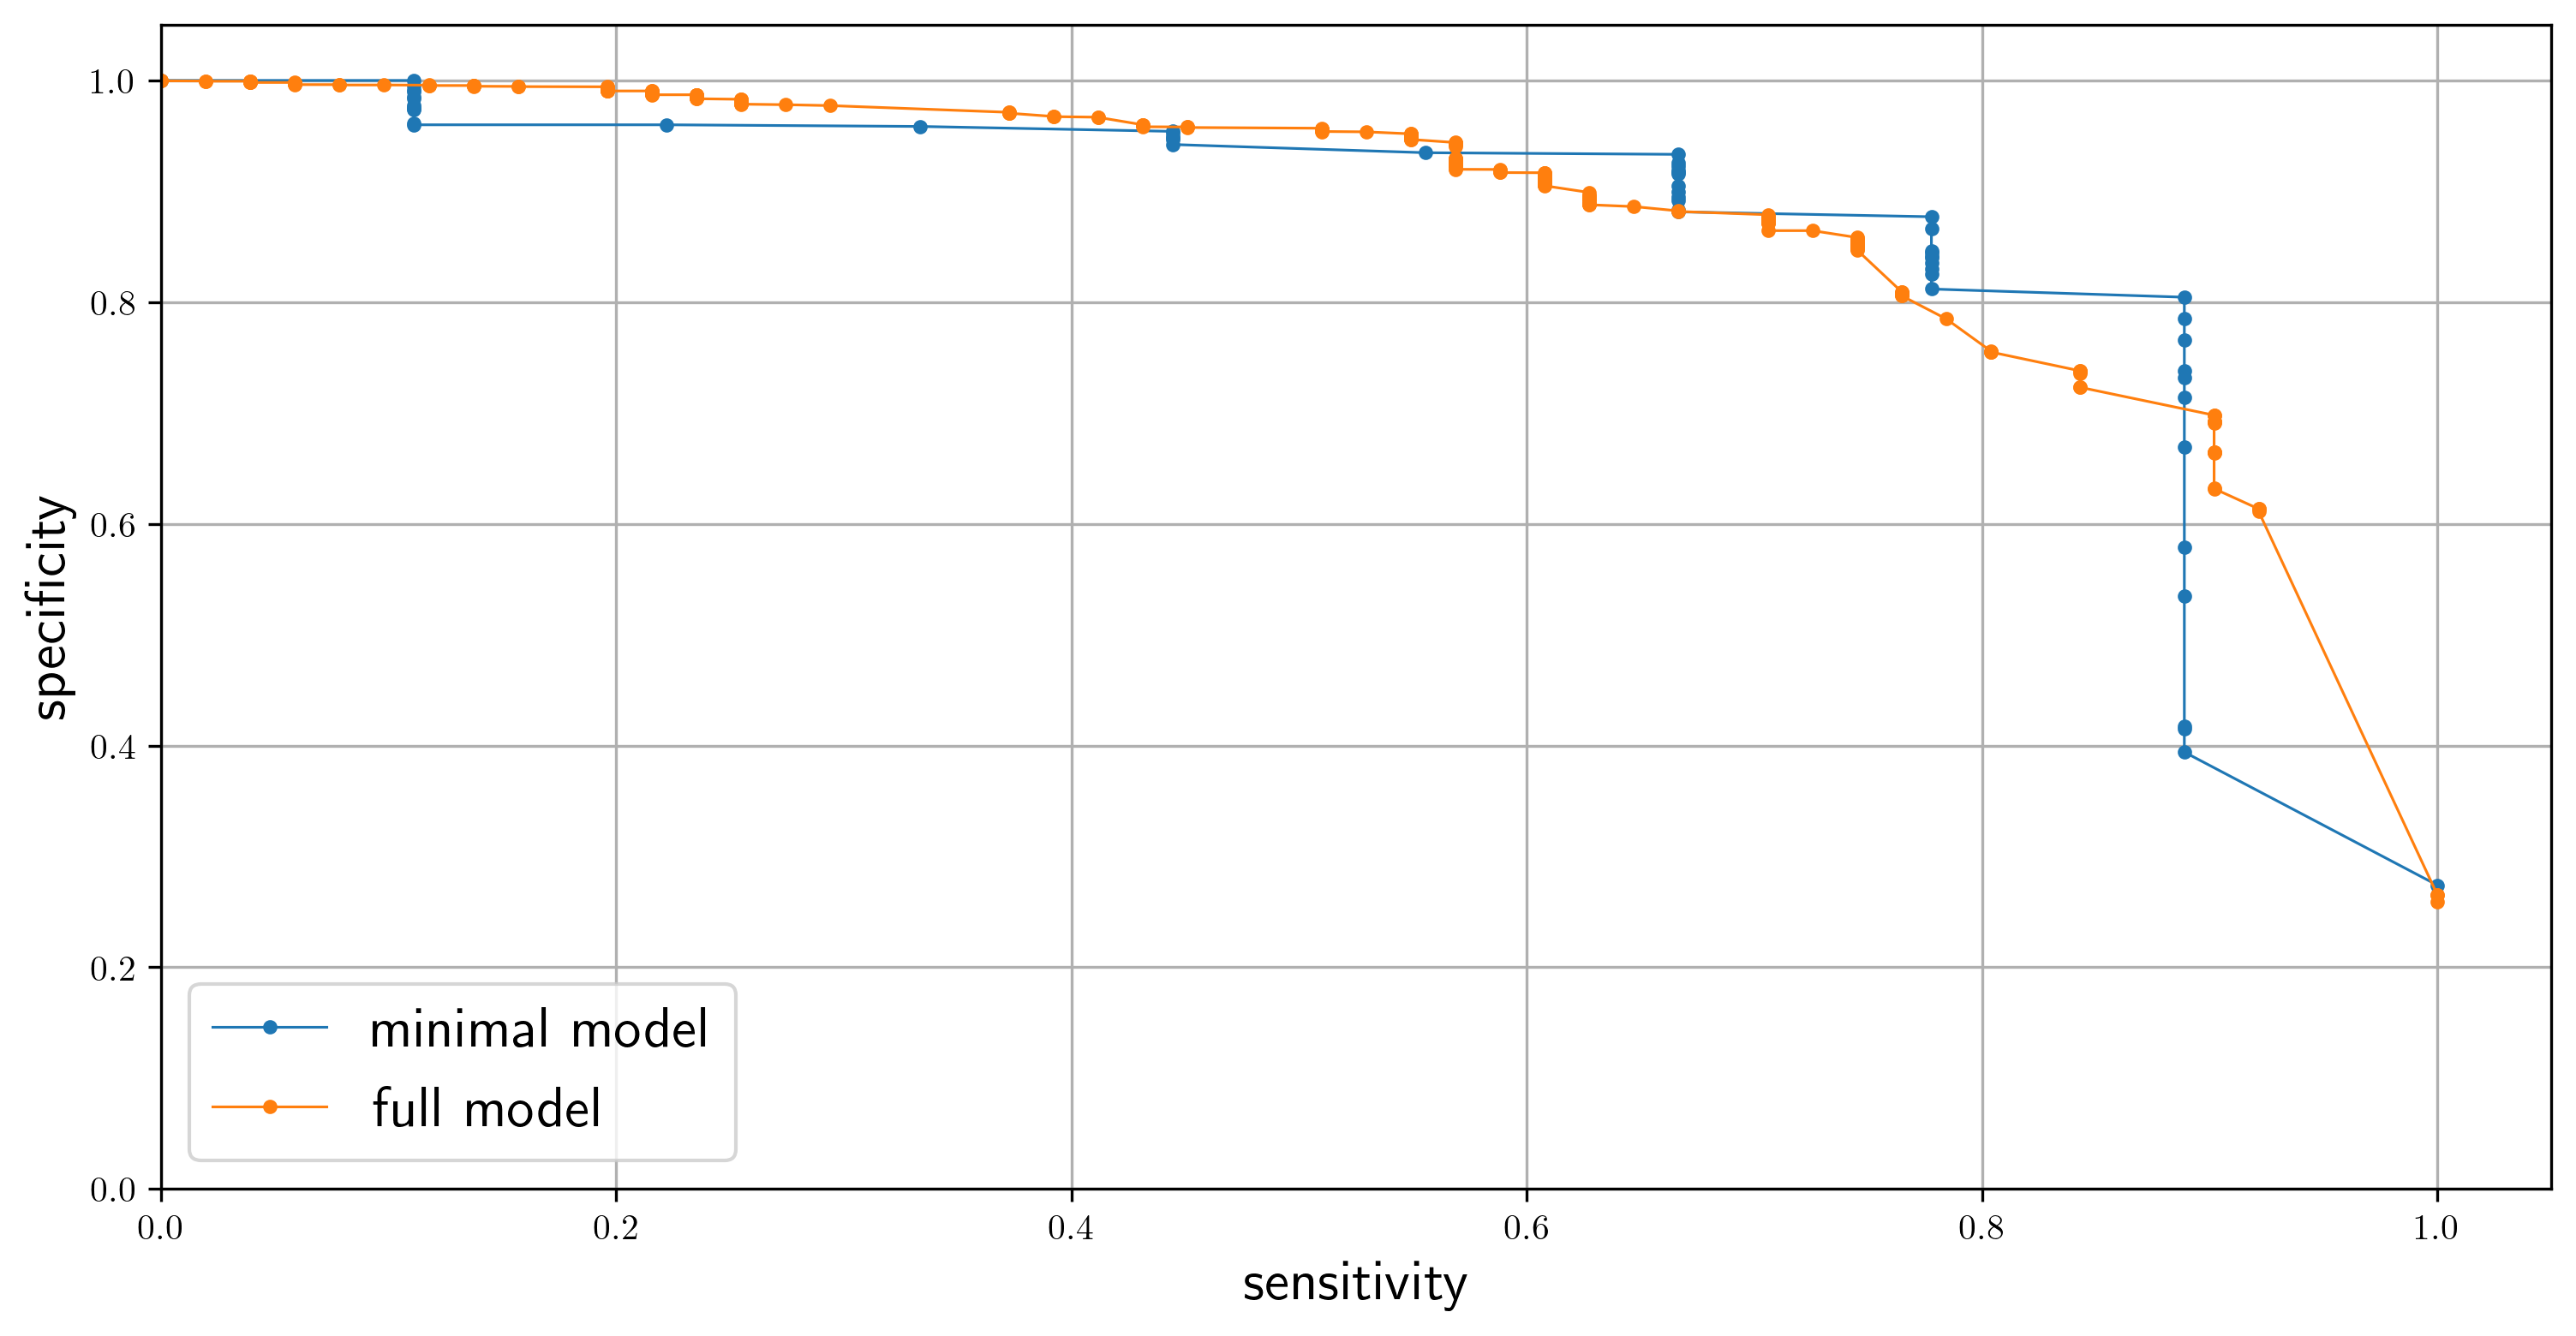

In [53]:
plt.plot(statsB['sens'], statsB['spec'], '.-')
plt.plot(statsM['sens'], statsM['spec'], '.-')
plt.xlabel('sensitivity', fontsize=16)
plt.ylabel('specificity', fontsize=16)
plt.grid()
plt.xlim(0, 1.05);
plt.ylim(0, 1.05);
plt.legend(["minimal model", "full model"], fontsize=16, loc="lower left");

In [41]:
rulesM = rulefitM.get_rules()
rulesM = rulesM[rulesM['type']!='linear']
rulesM = rulesM.sort_values('importance', ascending=False) 
rulesM

,rule,type,coef,support,importance
179,ClavNeck_1 <= 0.5 and AMS <= 0.5 and SFxBasHem...,rule,-1.042762,0.890244,0.325952
174,SFxBasOto_1 <= 0.5 and SFxBasRet_1 <= 0.5 and ...,rule,-0.707749,0.899741,0.212569
183,SFxBasRhi_92 > 0.5 and SFxPalp_0 > 0.5,rule,-1.095084,0.973397,0.176220
185,SFxBasPer_92 > 0.5 and SeizOccur_3 <= 0.5 and ...,rule,-0.664031,0.935085,0.163601
182,HemaSize_3 <= 0.5 and SFxBasHem_1 <= 0.5,rule,-0.444344,0.926937,0.115636
177,GCSVerbal > 0.5 and VomitLast_2 <= 0.5 and SFx...,rule,-0.341451,0.941938,0.079852
184,HemaSize_3 <= 0.5 and OSIFlank_1 <= 0.5 and SF...,rule,-0.251478,0.916253,0.069661
181,SFxBasOto_92 > 0.5 and AMSAgitated_1 <= 0.5 an...,rule,-0.080106,0.903518,0.023651
175,SeizOccur_2 <= 0.5 and SFxPalpDepress_1 <= 0.5...,rule,-0.181748,0.993039,0.015111
178,GCSVerbal > 0.5 and LocLen_4 <= 0.5 and GCSMot...,rule,-0.090114,0.978847,0.012967


In [42]:
rules = rulefitM.get_rules()
rules.loc[(rules.type =='linear') & (rules.coef != 0), :].sort_values("importance",
                                                                      ascending = False)

,rule,type,coef,support,importance
1,ActNorm,linear,-0.739527,1.0,0.275974
51,HA_verb_0,linear,-0.153310,1.0,0.074929
34,LOCSeparate_0,linear,-0.245106,1.0,0.072476
41,LocLen_92,linear,-0.033378,1.0,0.009870
